In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import copy

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from keras import layers, Model, Input

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)

c:\Users\User\miniconda3\envs\paper\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.7.0
1.22.3
4.7.0


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## load dataset

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

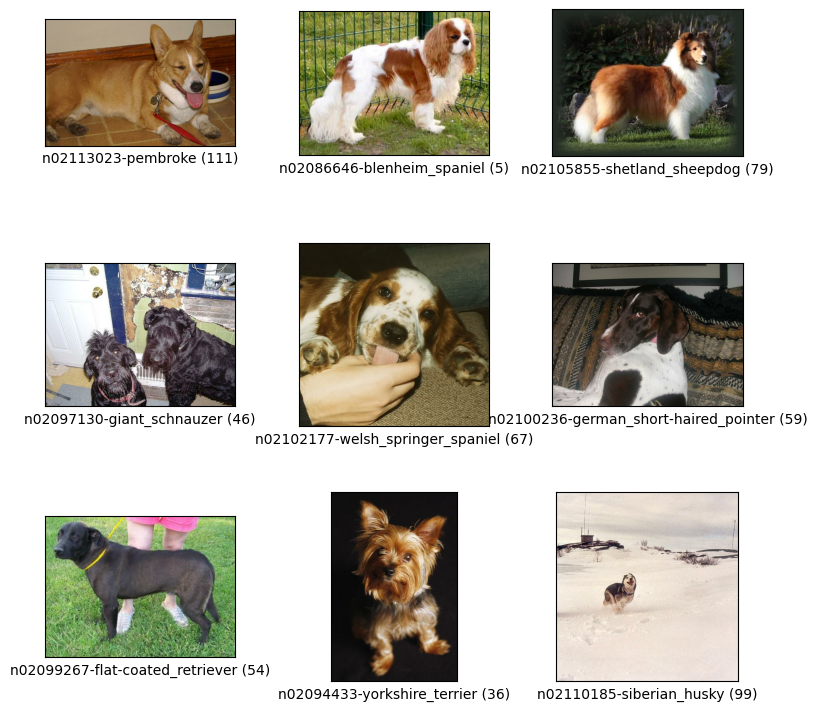

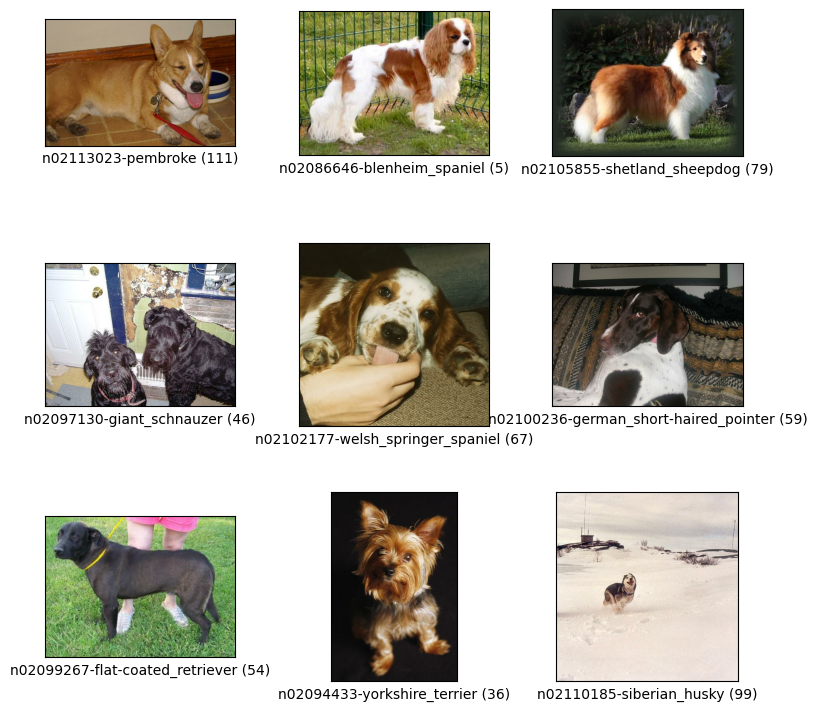

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

# CAM 구현하기

In [6]:
num_classes = ds_info.features['label'].num_classes
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, # 분류기만 떼어내기
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling = 'avg' # GAP 적용
)
x = base_model.output
preds = layers.Dense(num_classes, activation='softmax')(x)
cam_model = Model(inputs=base_model.input, outputs=preds)

In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## CAM 학습

### 전처리

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


### 학습

In [10]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [11]:
batch_size = 16
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=10,
    validation_data=ds_val_norm,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 34s 40ms/step - loss: 2.2383 - accuracy: 0.4391 - val_loss: 3.0980 - val_accuracy: 0.2449
Epoch 2/10
750/750 [==============================] - 30s 40ms/step - loss: 0.7483 - accuracy: 0.7947 - val_loss: 1.3715 - val_accuracy: 0.6090
Epoch 3/10
750/750 [==============================] - 30s 40ms/step - loss: 0.2730 - accuracy: 0.9430 - val_loss: 1.3808 - val_accuracy: 0.6117
Epoch 4/10
750/750 [==============================] - 30s 40ms/step - loss: 0.1136 - accuracy: 0.9851 - val_loss: 1.1070 - val_accuracy: 0.6872
Epoch 5/10
750/750 [==============================] - 30s 40ms/step - loss: 0.0594 - accuracy: 0.9950 - val_loss: 1.0056 - val_accuracy: 0.7250
Epoch 6/10
750/750 [==============================] - 30s 41ms/step - loss: 0.0383 - accuracy: 0.9967 - val_loss: 1.0056 - val_accuracy: 0.7276
Epoch 7/10
750/750 [==============================] - 31s 41ms/step - loss: 0.0235 - accuracy: 0.9979 - val_loss: 0.9577 - val_accuracy:

In [12]:
cam_model_path = './data/CAM/models/CAM'
cam_model.save(cam_model_path)

INFO:tensorflow:Assets written to: ./data/CAM/models/CAM\assets


INFO:tensorflow:Assets written to: ./data/CAM/models/CAM\assets
c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### 시각화

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [14]:
cam_model_path = './data/CAM/models/CAM'
cam_model = tf.keras.models.load_model(cam_model_path)

In [16]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 필요한 부분만 떼오기
    cam_model = Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0,:,:,:]
    
    # 모델의 weight activation 얻기
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_output의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도를 나타낼 것이다
        cam_image += w * conv_outputs[:,:,i]
    
    cam_image /= np.max(cam_image) # normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지 크기로 resize
    return cam_image
        

80


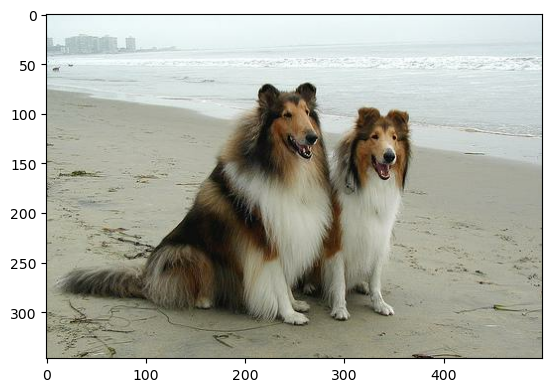

In [19]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

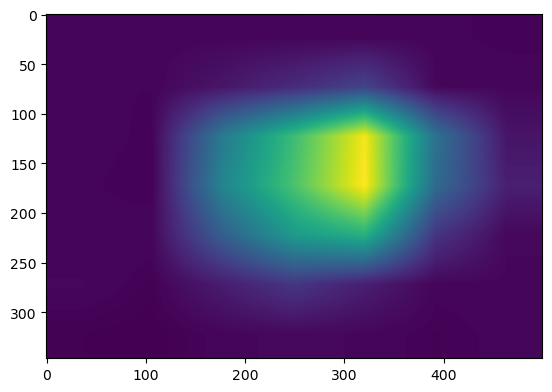

In [21]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [22]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

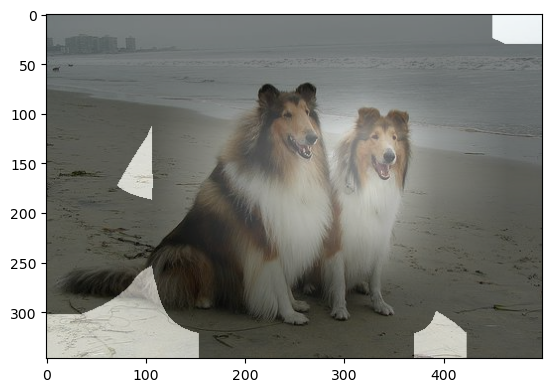

In [28]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

강아지의 얼굴, 몸통 부분을 보고 있다.

# Grad-CAM 구현하기

In [32]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 필요한 부분만 떼오기
    grad_model = Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient 얻어오기
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx] # 원하는 class
        output = conv_output[0] # 원하는 layer의 output
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 layer의 gradient
    
    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP로 weight를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻음
        grad_cam_image += w * output[:,:,k]
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image) #normalize
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image  
    

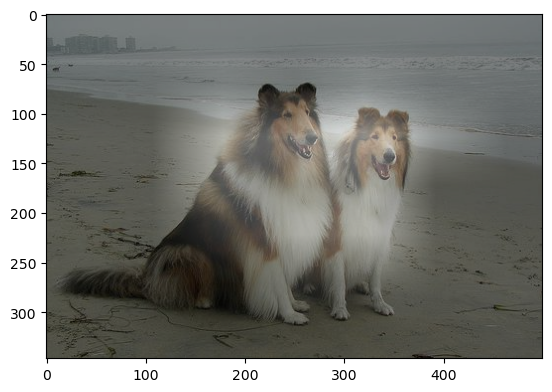

In [37]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

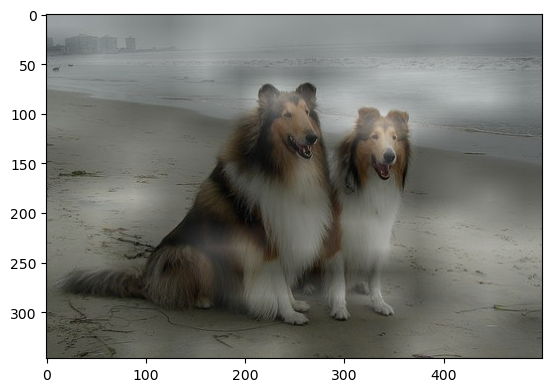

In [38]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

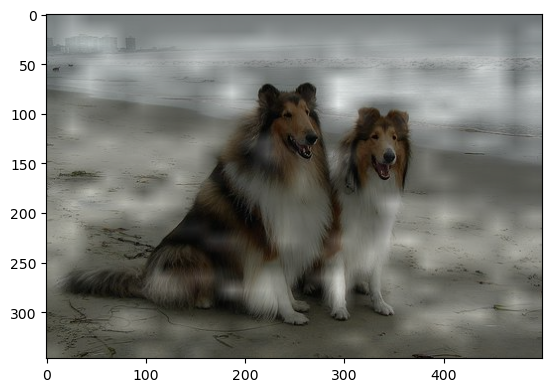

In [39]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

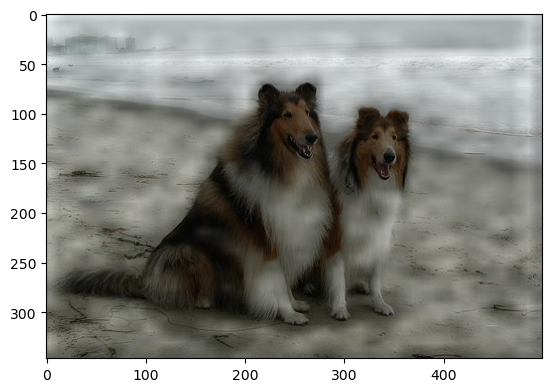

In [41]:
grad_cam_image = generate_grad_cam(cam_model, 'conv2_block3_out', item)
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

grad cam 결과로 conv층이 깊어질수록 목표 물체의 특징을 본다는 것을 알 수 있었다.

# Detection 수행

67


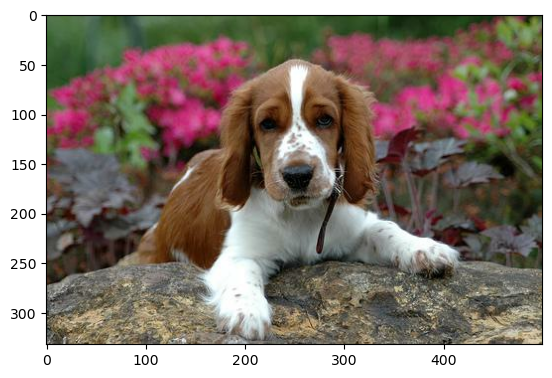

In [71]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [72]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

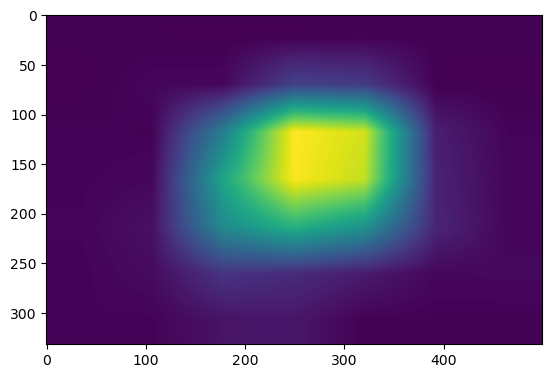

In [73]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

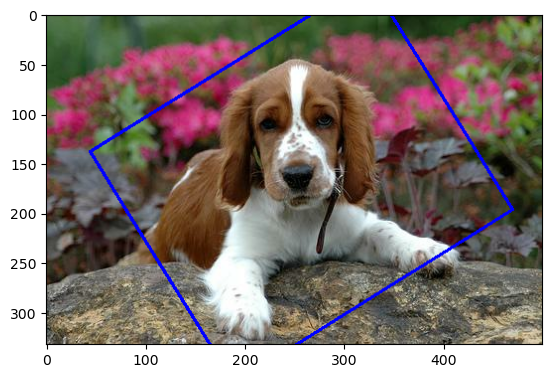

In [74]:
rect = get_bbox(cam_image)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

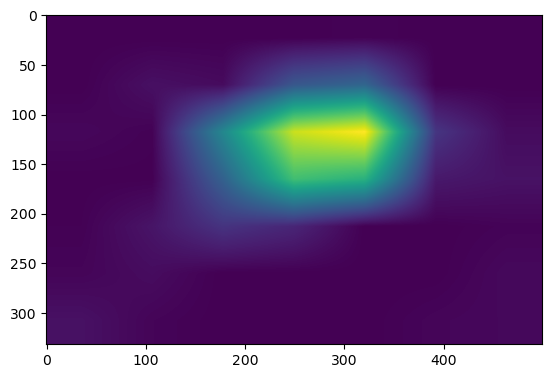

In [75]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out',item)
plt.imshow(grad_cam_image)
plt.show()

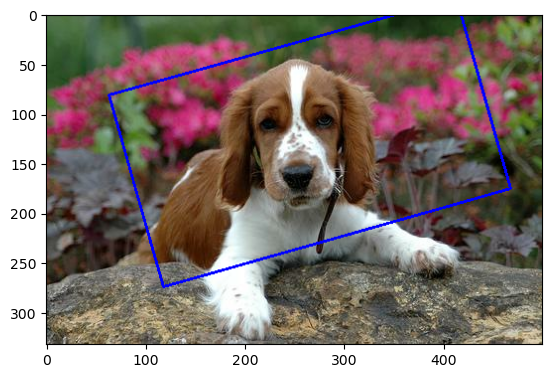

In [76]:
grad_rect = get_bbox(grad_cam_image)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

눈으로 봤을 때 CAM은 다리까지 잡아내는 반면 Grad-CAM은 좀더 얼굴과 몸통 좁은 범위를 보고 있다.

# IOU 비교
rect의 좌표가 (x,y): (y_min, x_min, y_max, x_max)의 normalized 형태로 주어져 있으므로 바꿔주는 작업이 필요하다.

In [78]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [79]:
pred_bbox = rect_to_minmax(rect, item['image'])
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])

In [80]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [81]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5549595561455845

In [82]:
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.5715963127710916

Grad-CAM의 IOU가 좀더 좋았다. 이는 원래 그려저있는 bbox의 범위와의 차이 때문으로 보인다. 따라서 눈으로 봤을 때 더 좋은 CAM이 Grad-CAM보다 물체를 더 잘 포착한다고 생각한다.

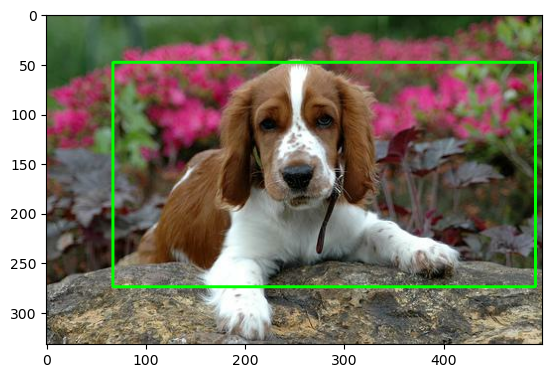

In [101]:
# 원래 bbox
bbox = item['objects']['bbox']
image = copy.deepcopy(item['image'])
xmin = int(bbox[0][0] * image.shape[1])
ymin = int(bbox[0][1] * image.shape[0])
xmax = int(bbox[0][2] * image.shape[1])
ymax = int(bbox[0][3] * image.shape[0])

# Draw a rectangle on the image
cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
plt.imshow(image)
plt.show()